In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
import os
import pandas as pd
import matplotlib.pyplot as plt
import keras
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
from tqdm import tqdm
import warnings
from keras.layers import *
from keras import backend as keras
from keras import Model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

In [2]:
warnings.filterwarnings('ignore')
plt.rcParams["figure.dpi"] = 120
image_height = 256
image_width = 256
image_depth = 1
epochs=100
batch_size = 32
epoch_index = [i for i in range(1, epochs+1)]

#### Load data

In [3]:
raw_images = np.load(os.path.join("Brain_MRI_data1", "images.npy"), allow_pickle=True)
raw_masks = np.load(os.path.join("Brain_MRI_data1", "masks.npy"), allow_pickle=True)

#### Change all image to grey

In [3]:
image_index = 0
for image in tqdm(raw_images):
    plt.imsave(os.path.join("Brain_MRI_Segment_image", "image_{}.jpg".format(image_index)), image, cmap="gray")
    image_index += 1

mask_index = 0
for mask in tqdm(raw_masks):
    plt.imsave(os.path.join("Brain_MRI_Segment_mask", "mask_{}.jpg".format(mask_index)), mask, cmap="gray")
    mask_index += 1

NameError: name 'raw_images' is not defined

In [4]:
image_dir_name = "Brain_MRI_Segment_image"
mask_dir_name = "Brain_MRI_Segment_mask"
image_list = list()
mask_list = list()

images_dir = sorted(os.listdir(image_dir_name))
for image in tqdm(images_dir):
    current_image = cv2.imread(os.path.join(image_dir_name, image))
    current_image = cv2.resize(current_image, (image_height, image_width)).astype("float32")
    # current_image -= current_image.mean()
    # current_image /= current_image.std()
    # current_image_180 = cv2.rotate(current_image, cv2.ROTATE_180)
    # current_image_r90 = cv2.rotate(current_image, cv2.ROTATE_90_CLOCKWISE)
    # current_image_l90 = cv2.rotate(current_image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    image_list.append(current_image)
    # image_list.append(current_image_180)
    # image_list.append(current_image_r90)
    # image_list.append(current_image_l90)



masks_dir = sorted(os.listdir(mask_dir_name))
for mask in tqdm(masks_dir):
    current_mask = cv2.imread(os.path.join(mask_dir_name, mask), cv2.IMREAD_GRAYSCALE)
    current_mask = cv2.resize(current_mask, (image_height, image_width)).astype("float32")
    # current_mask -= current_mask.mean()
    # current_mask /= current_mask.std()
    # current_mask_180 = cv2.rotate(current_mask, cv2.ROTATE_180)
    # current_mask_r90 = cv2.rotate(current_mask, cv2.ROTATE_90_CLOCKWISE)
    # current_mask_l90 = cv2.rotate(current_mask, cv2.ROTATE_90_COUNTERCLOCKWISE)
    mask_list.append(current_mask)
    # mask_list.append(current_mask_180)
    # mask_list.append(current_mask_r90)
    # mask_list.append(current_mask_l90)


features = np.array(image_list)/255.0
masks = np.array(mask_list)/255.0
# masks = (masks > 0).astype(int)
masks = masks.reshape((masks.shape[0], masks.shape[1], masks.shape[2], 1))

100%|██████████| 3064/3064 [00:02<00:00, 1393.10it/s]


In [5]:
print("image dimension: {}, label dimension: {}".format(features.shape, masks.shape))

image dimension: (3064, 256, 256, 3), label dimension: (3064, 256, 256, 1)


#### Train, Test, Validation Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(features, masks, test_size=0.25, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(features, masks, test_size=0.25, random_state=42, shuffle=True)
# y_train = y_train.astype('float32')
# y_test = y_test.astype('float32')
# y_val = y_val.astype("float32")

In [7]:
# Save model function
def save_model(model_name, monitor):
    checkpoint = tf.keras.callbacks.ModelCheckpoint(os.path.join("trained_model_weights", model_name),
                                                    monitor=monitor,
                                                    verbose=1,
                                                    save_best_only=True,
                                                    mode='max')
    return [checkpoint]

#### Define ResxUnet

In [8]:
def resblock(X, f):
    '''
    function for creating res block
    '''
    X_copy = X  #copy of input

    # main path
    X = Conv2D(f, kernel_size=(1,1), kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)

    X = Conv2D(f, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)

    # shortcut path
    X_copy = Conv2D(f, kernel_size=(1,1), kernel_initializer='he_normal')(X_copy)
    X_copy = BatchNormalization()(X_copy)

    # Adding the output from main path and short path together
    X = Add()([X, X_copy])
    X = Activation('relu')(X)

    return X

def upsample_concat(x, skip):
    '''
    funtion for upsampling image
    '''
    X = UpSampling2D((2,2))(x)
    merge = Concatenate()([X, skip])

    return merge

def ResXUnet(input_shape=(256, 256, 3)):
    X_input = Input(input_shape) #iniating tensor of input shape

    # Stage 1
    conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(X_input)
    conv_1 = BatchNormalization()(conv_1)
    conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv_1)
    conv_1 = BatchNormalization()(conv_1)
    pool_1 = MaxPool2D((2,2))(conv_1)

    # stage 2
    conv_2 = resblock(pool_1, 32)
    pool_2 = MaxPool2D((2,2))(conv_2)

    # Stage 3
    conv_3 = resblock(pool_2, 64)
    pool_3 = MaxPool2D((2,2))(conv_3)

    # Stage 4
    conv_4 = resblock(pool_3, 128)
    pool_4 = MaxPool2D((2,2))(conv_4)

    # Stage 5 (bottle neck)
    conv_5 = resblock(pool_4, 256)

    # Upsample Stage 1
    up_1 = upsample_concat(conv_5, conv_4)
    up_1 = resblock(up_1, 128)

    # Upsample Stage 2
    up_2 = upsample_concat(up_1, conv_3)
    up_2 = resblock(up_2, 64)

    # Upsample Stage 3
    up_3 = upsample_concat(up_2, conv_2)
    up_3 = resblock(up_3, 32)

    # Upsample Stage 4
    up_4 = upsample_concat(up_3, conv_1)
    up_4 = resblock(up_4, 16)

    # final output
    out = Conv2D(1, (1,1), kernel_initializer='he_normal', padding='same', activation='sigmoid')(up_4)
    return Model(X_input, out)

#### Loss Function for ResXUnet

In [9]:
epsilon = 1e-5
def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + 1)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + 1)

def focal_tversky(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

#### Define U-Net

In [10]:
def unet(pretrained_weights = None,input_size = (256,256,3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv1)
    bn_1 = BatchNormalization(axis=3)(conv1)
    act_1 = Activation('relu')(bn_1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(act_1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv2)
    bn_2 = BatchNormalization(axis=3)(conv2)
    act_2 = Activation('relu')(bn_2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(act_2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv3)
    bn_3 = BatchNormalization(axis=3)(conv3)
    act_3 = Activation('relu')(bn_3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(act_3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv4)
    bn_4 = BatchNormalization(axis=3)(conv4)
    act_4 = Activation('relu')(bn_4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(act_4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv5)
    bn_5 = BatchNormalization(axis=3)(conv5)
    act_5 = Activation('relu')(bn_5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(act_5))
    merge6 = concatenate([conv4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv6)
    bn_6 = BatchNormalization(axis=3)(conv6)
    act_6 = Activation('relu')(bn_6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(act_6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv7)
    bn_7 = BatchNormalization(axis=3)(conv7)
    act_7 = Activation('relu')(bn_7)


    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(act_7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv8)
    bn_8 = BatchNormalization(axis=3)(conv8)
    act_8 = Activation('relu')(bn_8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(act_8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = None, padding = 'same', kernel_initializer = 'he_normal')(conv9)
    bn_9 = BatchNormalization(axis=3)(conv9)
    act_9 = Activation('relu')(bn_9)

    conv10 = Conv2D(1, 1, activation = 'sigmoid')(act_9)

    model = Model(inputs=[inputs] , outputs = [conv10])
    return model

#### Loss Function for U-net

In [11]:
smooth =100
def iou(y_true, y_pred):
    intersection = keras.sum(y_true * y_pred)
    sum_ = keras.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2 * intersection + smooth) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

#### Train U-net

In [12]:
unet_path = "unet.hdf5"
model_Unet = unet(input_size=(image_height,image_width,3))
model_Unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-3/32, amsgrad=False),
              loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])
model_Unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d_1[0][0]                   
______________________________________________________________________________________________

In [12]:
unet_history = model_Unet.fit(x=X_train,
                              y=y_train,
                              epochs=epochs,
                              batch_size=8,
                              verbose=1,
                              validation_data=(X_val, y_val),
                              callbacks=save_model(unet_path, "val_iou"))

Epoch 1/100
288/288 [==============================] - 60s 174ms/step - loss: 0.9260 - binary_accuracy: 0.8594 - iou: 0.0390 - dice_coef: 0.0742 - val_loss: 0.9649 - val_binary_accuracy: 0.9762 - val_iou: 0.0184 - val_dice_coef: 0.0351

Epoch 00001: val_iou improved from -inf to 0.01845, saving model to trained_model_weights\unet.hdf5
Epoch 2/100
288/288 [==============================] - 47s 163ms/step - loss: 0.8450 - binary_accuracy: 0.9443 - iou: 0.0861 - dice_coef: 0.1558 - val_loss: 0.9388 - val_binary_accuracy: 0.9579 - val_iou: 0.0331 - val_dice_coef: 0.0613

Epoch 00002: val_iou improved from 0.01845 to 0.03314, saving model to trained_model_weights\unet.hdf5
Epoch 3/100
288/288 [==============================] - 47s 163ms/step - loss: 0.6787 - binary_accuracy: 0.9707 - iou: 0.1972 - dice_coef: 0.3225 - val_loss: 0.7126 - val_binary_accuracy: 0.9502 - val_iou: 0.1721 - val_dice_coef: 0.2873

Epoch 00003: val_iou improved from 0.03314 to 0.17205, saving model to trained_model_w

Text(0.5, 1.0, 'Unet for segmentation')

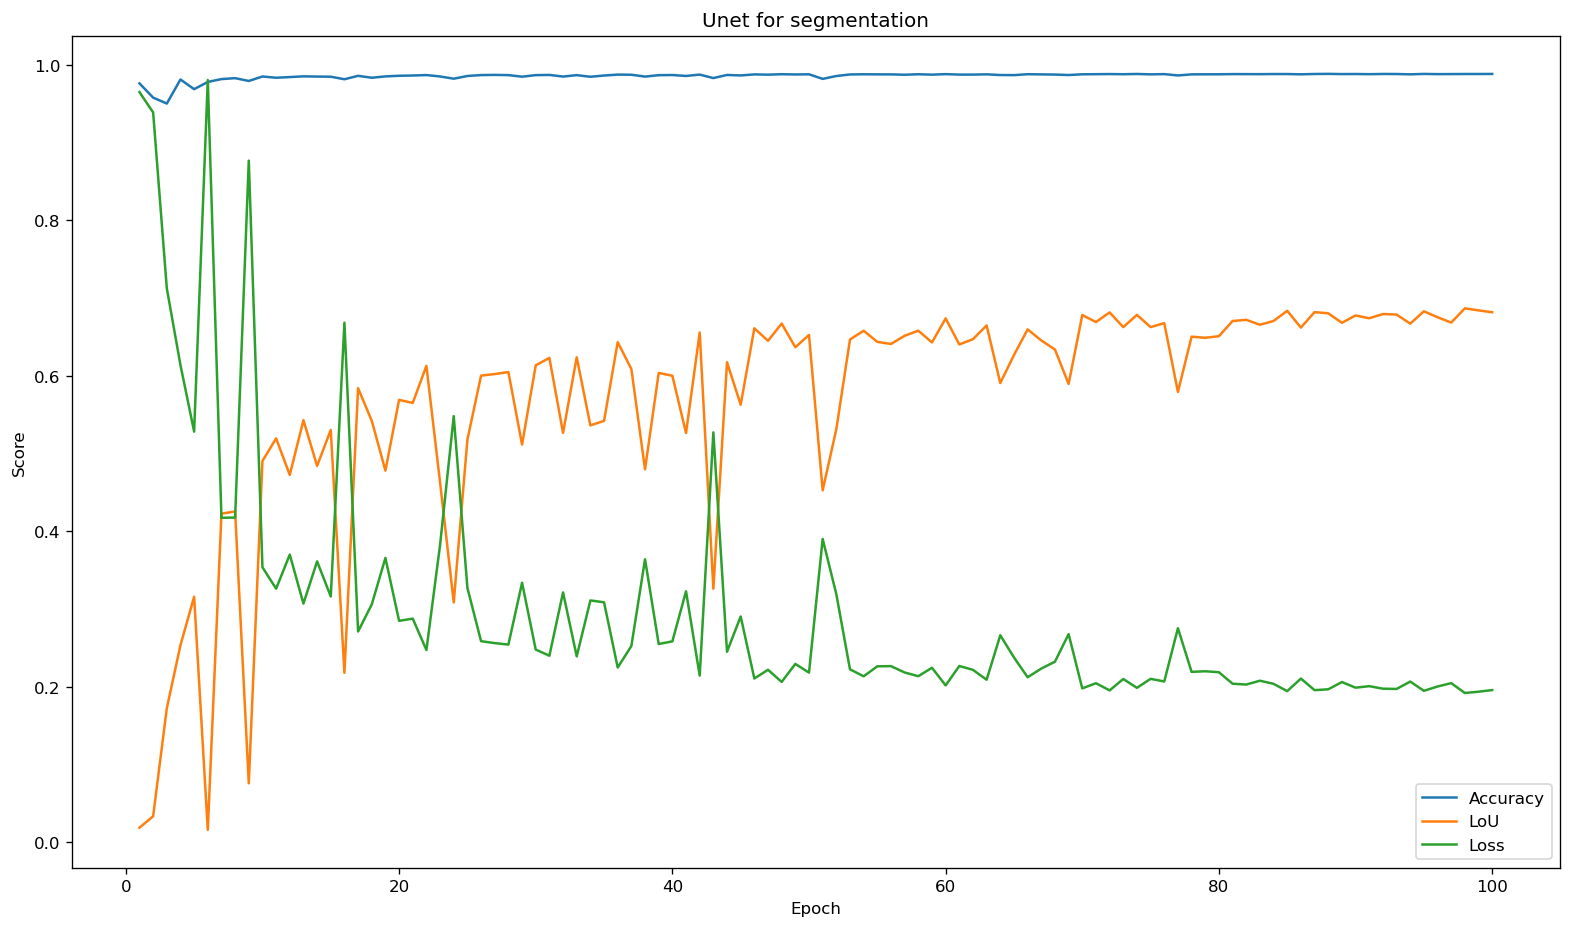

In [22]:
model_Unet_result = pd.DataFrame({"Accuracy": unet_history.history["val_binary_accuracy"],
                                  "LoU": unet_history.history["val_iou"],
                                  "Loss": unet_history.history["val_loss"]}, index=epoch_index)
model_Unet_result.to_csv("Unet_result.csv")
ax_unet = model_Unet_result.plot.line(figsize=(16, 9))
ax_unet.set_xlabel("Epoch")
ax_unet.set_ylabel("Score")
ax_unet.set_title("Unet for segmentation")

In [15]:
model_Unet.load_weights(os.path.join("trained_model_weights", unet_path))
model_Unet.evaluate(x=X_test, y=y_test)

ResourceExhaustedError:  OOM when allocating tensor with shape[32,128,257,257] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node model/conv2d_19/Relu (defined at \AppData\Local\Temp\ipykernel_19652\2600478073.py:1) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_test_function_5523]

Function call stack:
test_function


#### Train ResXUnet

In [13]:
res_unet_path = "res_unet.hdf5"
model_res_unet = ResXUnet((256, 256, 3))
model_res_unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-3/32, amsgrad=False),
              loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])
model_res_unet.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 256, 256, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_9 (BatchNor (None, 256, 256, 16) 64          conv2d_24[0][0]                  
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 256, 256, 16) 2320        batch_normalization_9[0][0]      
____________________________________________________________________________________________

In [14]:
model_res_unet_history = model_res_unet.fit(x=X_train,
                                            y=y_train,
                                            epochs=epochs,
                                            validation_data=(X_val, y_val),
                                            callbacks=save_model(res_unet_path, "val_iou"),
                                            verbose=1)

Epoch 1/100
72/72 [==============================] - 21s 170ms/step - loss: 0.8461 - binary_accuracy: 0.8551 - iou: 0.0852 - dice_coef: 0.1541 - val_loss: 0.9682 - val_binary_accuracy: 0.1567 - val_iou: 0.0162 - val_dice_coef: 0.0318

Epoch 00001: val_iou improved from -inf to 0.01619, saving model to trained_model_weights\res_unet.hdf5
Epoch 2/100
72/72 [==============================] - 9s 124ms/step - loss: 0.5654 - binary_accuracy: 0.9783 - iou: 0.2819 - dice_coef: 0.4347 - val_loss: 0.9727 - val_binary_accuracy: 0.9251 - val_iou: 0.0141 - val_dice_coef: 0.0273

Epoch 00002: val_iou did not improve from 0.01619
Epoch 3/100
72/72 [==============================] - 9s 124ms/step - loss: 0.3849 - binary_accuracy: 0.9839 - iou: 0.4475 - dice_coef: 0.6149 - val_loss: 0.8181 - val_binary_accuracy: 0.9635 - val_iou: 0.1014 - val_dice_coef: 0.1817

Epoch 00003: val_iou improved from 0.01619 to 0.10137, saving model to trained_model_weights\res_unet.hdf5
Epoch 4/100
72/72 [=================

In [ ]:
model_res_unet.load_weights(os.path.join("trained_model_weights", unet_path))
model_res_unet.evaluate(x=X_test, y=y_test)

Text(0.5, 1.0, 'ResXUnet for segmentation')

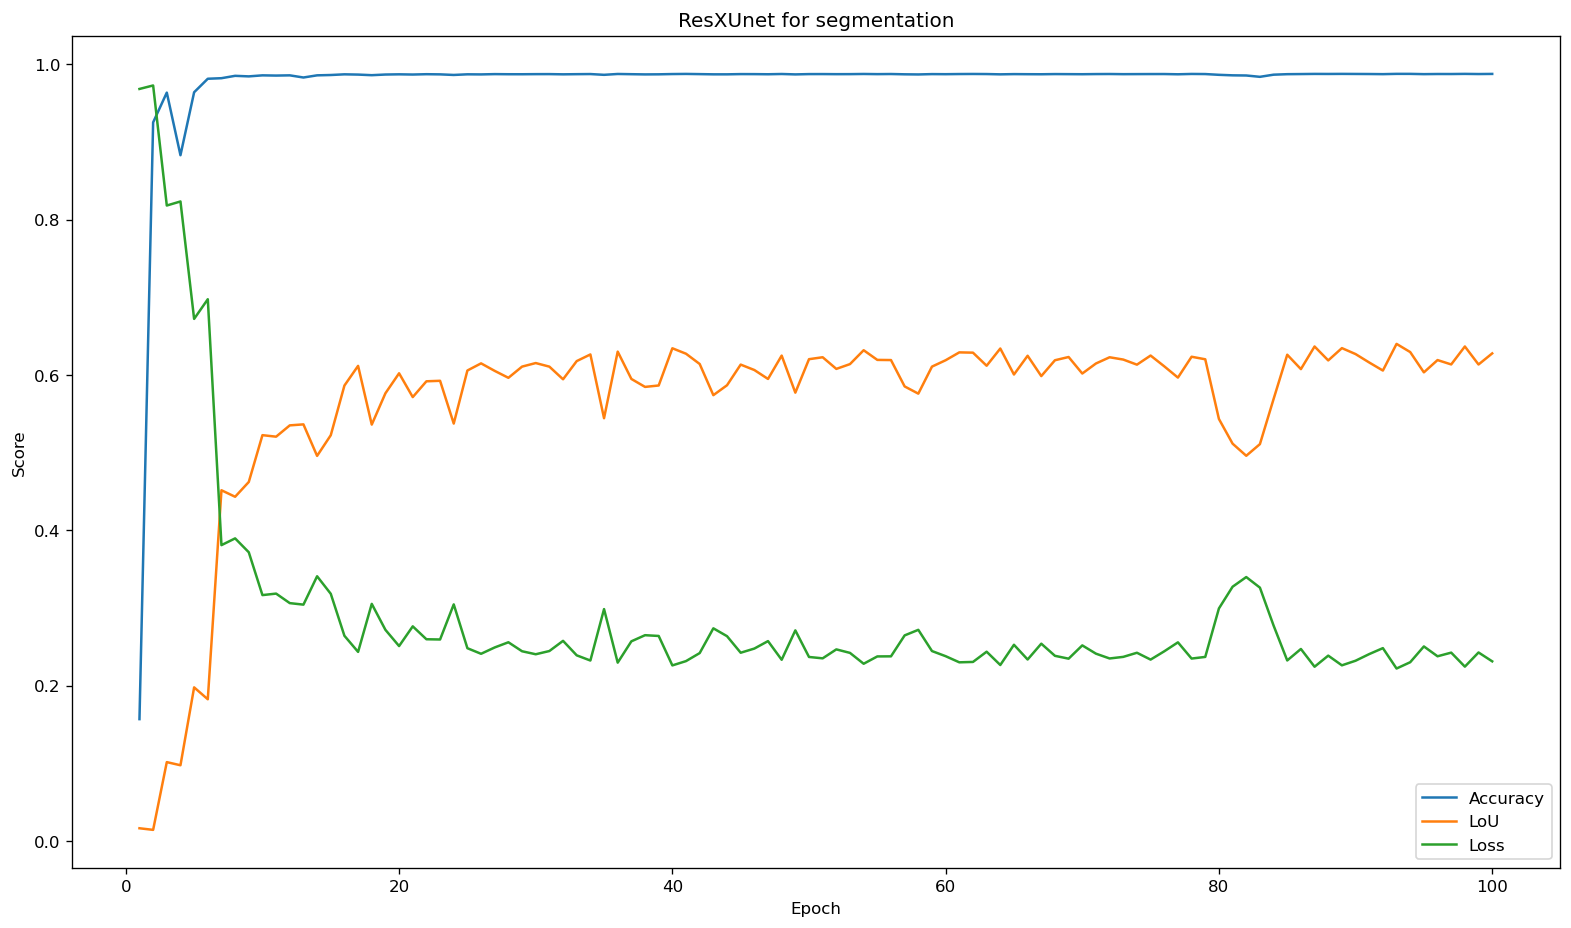

In [15]:
model_ResUnet_result = pd.DataFrame({"Accuracy": model_res_unet_history.history["val_binary_accuracy"],
                                  "LoU": model_res_unet_history.history["val_iou"],
                                  "Loss": model_res_unet_history.history["val_loss"]}, index=epoch_index)
model_ResUnet_result.to_csv("ResUnet_result.csv")
ax_ResUnet = model_ResUnet_result.plot.line(figsize=(16, 9))
ax_ResUnet.set_xlabel("Epoch")
ax_ResUnet.set_ylabel("Score")
ax_ResUnet.set_title("ResXUnet for segmentation")

In [17]:
unet_result = pd.read_csv("Unet_result.csv")
resunet_result = pd.read_csv("ResUnet_result.csv")

Text(0.5, 1.0, 'LoU test accuracy for segmentation')

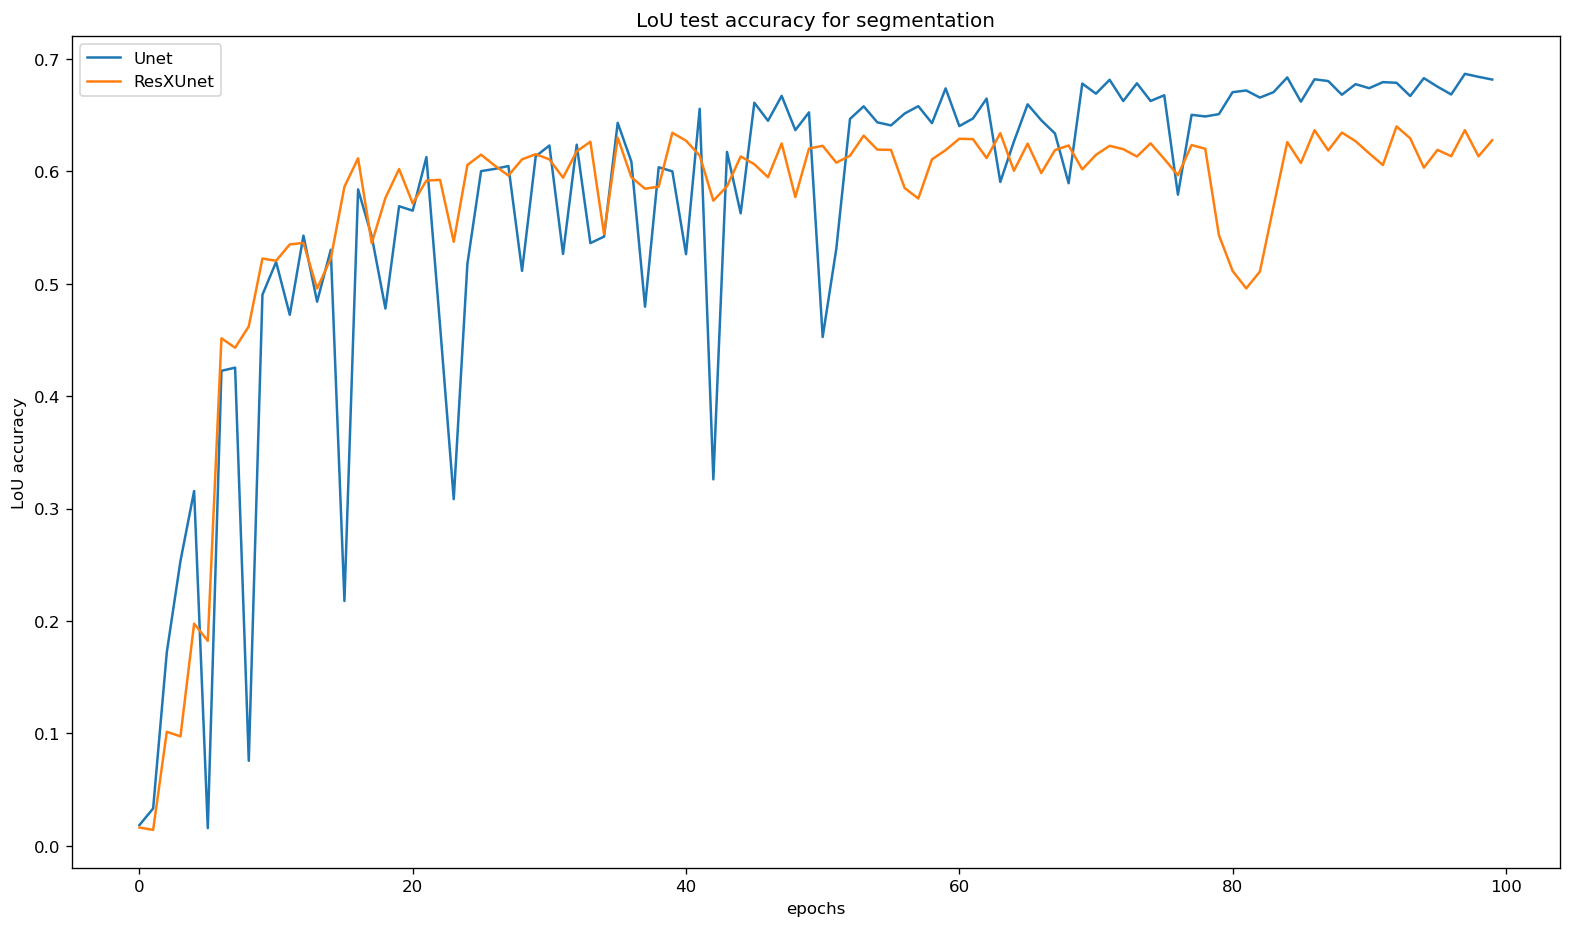

In [23]:
LoU = pd.DataFrame({"Unet": unet_result["LoU"], "ResXUnet": resunet_result['LoU']})
ax = LoU.plot.line(figsize=(16, 9))
ax.set_xlabel("epochs")
ax.set_ylabel("LoU accuracy")
ax.set_title("LoU test accuracy for segmentation")

Text(0.5, 1.0, 'LoU test Loss for segmentation')

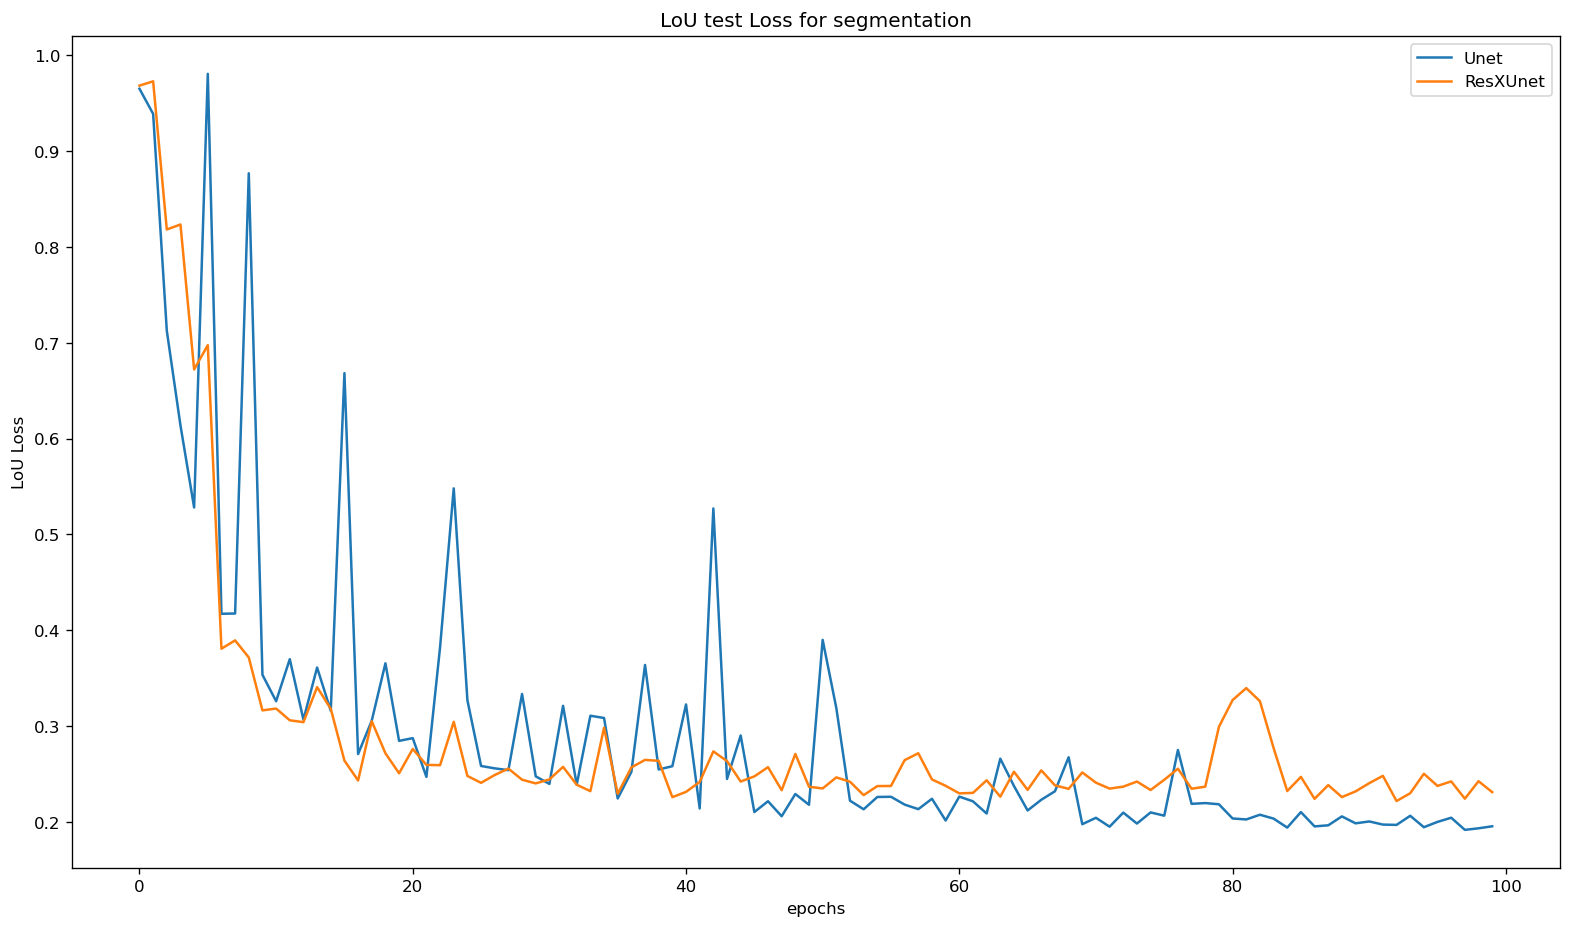

In [24]:
Loss = pd.DataFrame({"Unet": unet_result["Loss"], "ResXUnet": resunet_result['Loss']})
ax = Loss.plot.line(figsize=(16, 9))
ax.set_xlabel("epochs")
ax.set_ylabel("LoU Loss")
ax.set_title("LoU test Loss for segmentation")

In [47]:
test = X_test[1]
test = np.reshape(test, (1, 256, 256, 3))
truth = y_test[1]
truth = np.reshape(truth, (1, 256, 256, 1))

In [48]:
predicted = model_res_unet.predict(x=test)

In [49]:
model_res_unet.evaluate(x=test, y=truth)

1/1 [==============================] - 0s 38ms/step - loss: 0.2833 - tversky: 0.8139


[0.28333985805511475, 0.8139011859893799]

In [50]:
predicted = predicted.reshape(256, 256, 1)

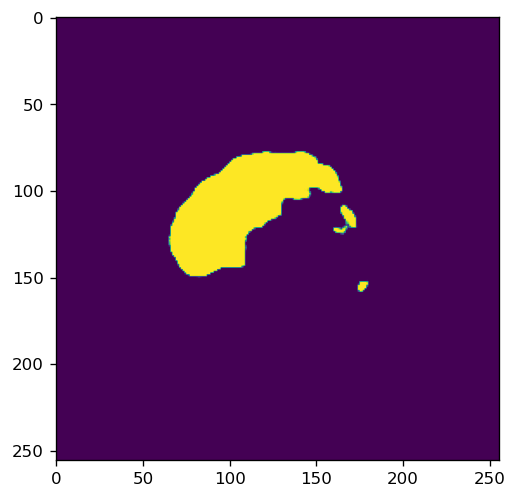

In [51]:
plt.imshow(predicted)

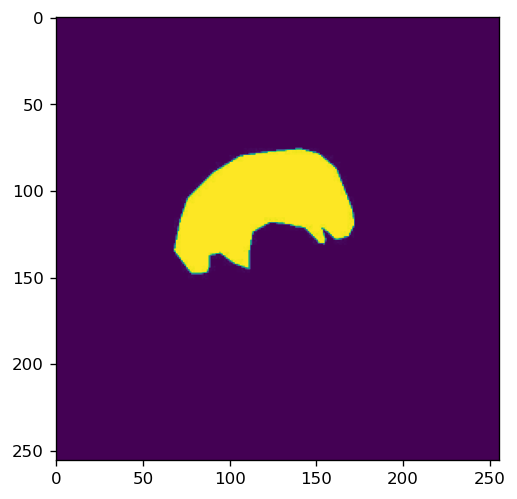

In [52]:
plt.imshow(truth[0])

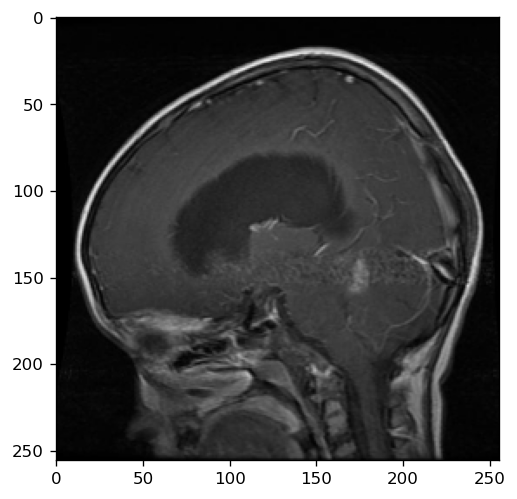

In [55]:
plt.imshow(test[0], cmap="gray")